In [37]:
#LSTM one-step price and sentiment as input
import numpy as np
import pandas as pd
import pylab as plt
import plotly.offline as py
import plotly.graph_objs as go
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
py.init_notebook_mode(connected=True)
%matplotlib inline

In [38]:
# dummy data
np.random.seed(1)
df = pd.DataFrame(np.random.rand(100, 2), columns=['price', 'sentiment'])
df['price'] = df['price']*100
df.head()

,price,sentiment
0,41.702200,0.720324
1,0.011437,0.302333
2,14.675589,0.092339
3,18.626021,0.345561
4,39.676747,0.538817


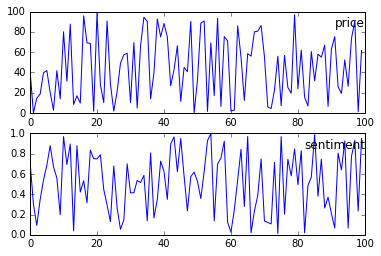

In [39]:
from matplotlib import pyplot
# plot each column
pyplot.figure()
pyplot.subplot(2, 1, 1)
pyplot.plot(df['price'])
pyplot.title('price', y=0.8, loc='right')
pyplot.subplot(2, 1, 2)
pyplot.plot(df['sentiment'])
pyplot.title('sentiment', y=0.8, loc='right')
pyplot.show()

In [40]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [41]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
values = values.astype('float32') # convert to float
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values) # normalised
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[3]], axis=1, inplace=True) # drop unwanted column
reframed.head()

,var1(t-1),var2(t-1),var1(t)
1,0.421653,0.718717,0.000000
2,0.000000,0.294259,0.148310
3,0.148310,0.081017,0.188264
4,0.188264,0.338156,0.401168
5,0.401168,0.534401,0.423850


In [42]:
reframed.shape

(99, 3)

In [43]:
# train and test set
split = 0.9
values = reframed.values
train = values[:int(len(values)*split), :]
test = values[int(len(values)*split):, :]
test.shape

(10, 3)

In [44]:
reframed.tail()

,var1(t-1),var2(t-1),var1(t)
95,0.530526,0.926363,0.266178
96,0.266178,0.054231,0.743316
97,0.743316,0.771372,0.918032
98,0.918032,0.933638,0.013995
99,0.013995,0.225237,0.623682


In [59]:
# split into input output
trainX, trainY = train[:, :-1], train[:, -1]
testX, testY = test[:, :-1], test[:, -1]

In [60]:
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

In [47]:
trainX.shape

(89, 1, 2)

In [48]:
trainX

array([[[0.42165264, 0.7187168 ]],

       [[0.        , 0.29425907]],

       [[0.1483105 , 0.08101675]],

       [[0.18826443, 0.3381559 ]],

       [[0.40116757, 0.53440136]],

       [[0.42384988, 0.6830688 ]],

       [[0.20666352, 0.8789506 ]],

       [[0.02758363, 0.66808856]],

       [[0.42193866, 0.5545818 ]],

       [[0.14186905, 0.18841566]],

       [[0.80974245, 0.97048914]],

       [[0.31687573, 0.69028175]],

       [[0.886248  , 0.89569485]],

       [[0.08589645, 0.02690871]],

       [[0.17164765, 0.878976  ]],

       [[0.09935048, 0.4148714 ]],

       [[0.968676  , 0.52866244]],

       [[0.699636  , 0.30764604]],

       [[0.69419855, 0.83478606]],

       [[0.01838075, 0.74899787]],

       [[1.0000001 , 0.7469886 ]],

       [[0.28352016, 0.78873825]],

       [[0.10428518, 0.44207165]],

       [[0.9188209 , 0.28540578]],

       [[0.29093498, 0.11928974]],

       [[0.0194717 , 0.67658603]],

       [[0.21392106, 0.2569041 ]],

       [[0.49705225, 0.04143

In [49]:
# LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]))) # LSTM layer, 100 units
model.add(Dense(1)) # fully connected layer
model.compile(loss='mae', optimizer='adam') # configure training process, mean absolute error

In [50]:
# iterate training batches
history = model.fit(trainX, trainY, epochs=50, batch_size=5, validation_data=(testX, testY), verbose=2, shuffle=False)

Train on 89 samples, validate on 10 samples
Epoch 1/50
 - 1s - loss: 0.3976 - val_loss: 0.3974
Epoch 2/50
 - 0s - loss: 0.3301 - val_loss: 0.3386
Epoch 3/50
 - 0s - loss: 0.3030 - val_loss: 0.3273
Epoch 4/50
 - 0s - loss: 0.2948 - val_loss: 0.3227
Epoch 5/50
 - 0s - loss: 0.2905 - val_loss: 0.3197
Epoch 6/50
 - 0s - loss: 0.2907 - val_loss: 0.3179
Epoch 7/50
 - 0s - loss: 0.2907 - val_loss: 0.3166
Epoch 8/50
 - 0s - loss: 0.2905 - val_loss: 0.3154
Epoch 9/50
 - 0s - loss: 0.2902 - val_loss: 0.3141
Epoch 10/50
 - 0s - loss: 0.2899 - val_loss: 0.3129
Epoch 11/50
 - 0s - loss: 0.2896 - val_loss: 0.3116
Epoch 12/50
 - 0s - loss: 0.2896 - val_loss: 0.3109
Epoch 13/50
 - 0s - loss: 0.2891 - val_loss: 0.3098
Epoch 14/50
 - 0s - loss: 0.2888 - val_loss: 0.3085
Epoch 15/50
 - 0s - loss: 0.2885 - val_loss: 0.3072
Epoch 16/50
 - 0s - loss: 0.2886 - val_loss: 0.3066
Epoch 17/50
 - 0s - loss: 0.2880 - val_loss: 0.3054
Epoch 18/50
 - 0s - loss: 0.2881 - val_loss: 0.3047
Epoch 19/50
 - 0s - loss: 0.2

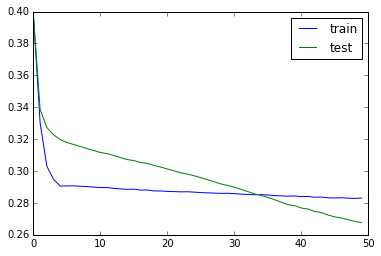

In [51]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [61]:
from sklearn.metrics import mean_squared_error
yhat = model.predict(testX)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, testX[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
testY = testY.reshape((len(testY), 1))
inv_y = np.concatenate((testY, testX[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 30.582
